In [1]:
import findspark
findspark.init()
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("sparkNlp") \
    .config("spark.jars.packages", "com.johnsnowlabs.nlp:spark-nlp_2.11:2.4.5") \
    .getOrCreate()

In [2]:
sc = spark.sparkContext

In [3]:
spark

In [5]:
from pyspark import SparkContext
from pyspark.sql.types import *
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, lit
from functools import reduce
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import matplotlib.pyplot as plt
from wordcloud import WordCloud 
import pandas as pd
import re
import string

# 2017

In [6]:
congDF0617 = spark.read.csv("s3://502finalprojbucky/congresstweets/data/June2017.csv/*.part",header=True)
congDF0717 = spark.read.csv("s3://502finalprojbucky/congresstweets/data/July2017.csv/*.part",header=True)
congDF0817 = spark.read.csv("s3://502finalprojbucky/congresstweets/data/Aug2017.csv/*.part",header=True)
congDF0917 = spark.read.csv("s3://502finalprojbucky/congresstweets/data/Sep2017.csv/*.part",header=True)
congDF1017 = spark.read.csv("s3://502finalprojbucky/congresstweets/data/Oct2017.csv/*.part",header=True)
congDF1117 = spark.read.csv("s3://502finalprojbucky/congresstweets/data/Nov2017.csv/*.part",header=True)
congDF1217 = spark.read.csv("s3://502finalprojbucky/congresstweets/data/Dec2017.csv/*.part",header=True)

In [7]:
cong_2017 = sc.union([congDF0617.rdd,congDF0717.rdd,
                  congDF0817.rdd,congDF0917.rdd,
                  congDF1017.rdd,congDF1117.rdd,
                  congDF1217.rdd]).toDF()

In [8]:
cong_2017.head(1)

[Row(_c0='0', id='879753852312006657', screen_name='ChrisCoons', time='2017-06-27T13:30:38-04:00', link='https://www.twitter.com/ChrisCoons/statuses/879753852312006657', text='Listen to these stories &amp; join us in the fight for more affordable, more accessible health care. http://pbs.twimg.com/media/DDWDa6DW0AAS3XZ.jpg', source='TweetDeck', user_id='15324851')]

In [9]:
cong_2017.printSchema()

root
 |-- _c0: string (nullable = true)
 |-- id: string (nullable = true)
 |-- screen_name: string (nullable = true)
 |-- time: string (nullable = true)
 |-- link: string (nullable = true)
 |-- text: string (nullable = true)
 |-- source: string (nullable = true)
 |-- user_id: string (nullable = true)



In [10]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /home/hadoop/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [11]:
nltk.download('stopwords')
nltk.download('words')

[nltk_data] Downloading package stopwords to /home/hadoop/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package words to /home/hadoop/nltk_data...
[nltk_data]   Unzipping corpora/words.zip.


True

In [12]:
# get the list of stopwords from nltk
from nltk.corpus import stopwords

eng_stopwords = stopwords.words('english')
eng_stopwords.append('rt')
eng_stopwords.append('qt')
eng_stopwords.append('&amp')
eng_stopwords.append('amp')
eng_stopwords.append('+')
eng_stopwords.append('w')
eng_stopwords.append('today')
eng_stopwords.append('live')
eng_stopwords.append('make')
eng_stopwords.append('hear')
eng_stopwords.append('meet')
eng_stopwords.append('thank')
eng_stopwords.append('see')
eng_stopwords.append('time')
eng_stopwords.append('day')
eng_stopwords.append('watch')
eng_stopwords.append('get')
eng_stopwords.append('th')
eng_stopwords.append('year')
eng_stopwords.append('la')
eng_stopwords.append('pm')
eng_stopwords.append('hr')
eng_stopwords.append('rep')
eng_stopwords.append('come')
eng_stopwords.append('last')
eng_stopwords.append('dc')

In [13]:
from sparknlp.base import Finisher, DocumentAssembler
from sparknlp.annotator import (Tokenizer, Normalizer, 
                                LemmatizerModel, StopWordsCleaner)
from pyspark.ml import Pipeline
import pyspark.sql.functions as f

In [14]:
##### _c5 is the tweet
documentAssembler = DocumentAssembler() \
    .setInputCol('text') \
    .setOutputCol('document')

tokenizer = Tokenizer() \
    .setInputCols(['document']) \
    .setOutputCol('token')

# note normalizer defaults to changing all words to lowercase.
# Use .setLowercase(False) to maintain input case.
normalizer = Normalizer() \
    .setInputCols(['token']) \
    .setOutputCol('normalized') \
    .setLowercase(True)

# note that lemmatizer needs a dictionary. So I used the pre-trained
# model (note that it defaults to english)
lemmatizer = LemmatizerModel.pretrained() \
    .setInputCols(['normalized']) \
    .setOutputCol('lemma') \

stopwords_cleaner = StopWordsCleaner() \
    .setInputCols(['lemma']) \
    .setOutputCol('clean_lemma') \
    .setCaseSensitive(False) \
    .setStopWords(eng_stopwords)

# finisher converts tokens to human-readable output
finisher = Finisher() \
    .setInputCols(['clean_lemma']) \
    .setCleanAnnotations(False)

lemma_antbnc download started this may take some time.
Approximate size to download 907.6 KB
[OK!]


In [15]:
pipeline = Pipeline() \
    .setStages([
        documentAssembler,
        tokenizer,
        normalizer,
        lemmatizer,
        stopwords_cleaner,
        finisher
    ])

In [16]:
data = cong_2017.filter(cong_2017['text'].isNull() == False)

In [17]:
cong_2017_token = pipeline.fit(data).transform(data)

In [18]:
cong_2017_token.columns

['_c0',
 'id',
 'screen_name',
 'time',
 'link',
 'text',
 'source',
 'user_id',
 'document',
 'token',
 'normalized',
 'lemma',
 'clean_lemma',
 'finished_clean_lemma']

In [19]:
cong_2017_token.select('finished_clean_lemma').show(20)

+--------------------+
|finished_clean_lemma|
+--------------------+
|[listen, story, j...|
|[homelanddems, ra...|
|[ladepthealth, re...|
|[victory, america...|
|[realdonaldtrump,...|
|[tell, press, hou...|
|[republican, drea...|
|[wotus, gross, ov...|
|[keithrschmidt, r...|
|[icemarkets, clea...|
|[instead, help, s...|
|[great, news, can...|
|[senate, delay, v...|
|[sure, realdonald...|
|[proud, support, ...|
|[chcbvt, senatorl...|
|[fightfor, truth,...|
|[im, proud, prote...|
|[ambassador, nikk...|
|[cffoundation, jo...|
+--------------------+
only showing top 20 rows



In [20]:
# expand the "finished_clean_lemma" column so that the words are not in a list
from pyspark.sql.functions import explode, col

all_words = cong_2017_token.withColumn("Most_Frequent_Words", explode(col("finished_clean_lemma")))

In [21]:
all_words.select('Most_Frequent_Words').show(5)

+-------------------+
|Most_Frequent_Words|
+-------------------+
|             listen|
|              story|
|               join|
|              fight|
|         affordable|
+-------------------+
only showing top 5 rows



In [22]:
counts = all_words.groupby('Most_Frequent_Words').count()

In [23]:
counts

DataFrame[Most_Frequent_Words: string, count: bigint]

In [24]:
counts.show(5)

+--------------------+-----+
| Most_Frequent_Words|count|
+--------------------+-----+
|               input|  156|
|           cosponsor|  374|
|     httpfbmejqnvdlt|    1|
|httppbstwimgcomme...|    1|
|                hope| 1573|
+--------------------+-----+
only showing top 5 rows



In [25]:
from pyspark.sql.functions import *
counts_pd = counts.orderBy(desc('count')).toPandas()

In [26]:
counts_pd

Most_Frequent_Words  count
0                                            bill  12571
1                                        american  10705
2                                            work  10382
3                                           trump  10240
4                                          health   9964
...                                           ...    ...
235832   httpswwwtwittercomrightwisconsinstatuses      1
235833  httpswwwtwittercomescalantechambrstatuses      1
235834      httpswwwtwittercommollyhooperstatuses      1
235835            httpswwwtwittercomcvcoastatuses      1
235836           httpswwwtwittercombunnytstatuses      1

[235837 rows x 2 columns]

In [27]:
counts_pd.shape

(235837, 2)

In [28]:
counts_pd2 = counts_pd.head(15)

In [29]:
counts_pd2

Most_Frequent_Words  count
0                 bill  12571
1             american  10705
2                 work  10382
3                trump  10240
4               health   9964
5                 care   9530
6                great   8966
7                 need   8460
8                 help   8272
9                 vote   7430
10               house   7085
11              people   6948
12                must   6886
13              family   6782
14                join   6537

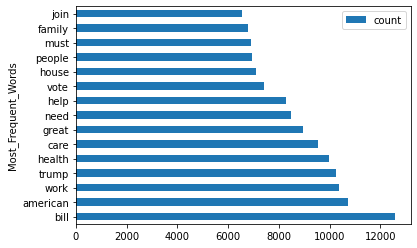

In [30]:
ax = counts_pd2.plot.barh(x='Most_Frequent_Words', y='count', rot=0)

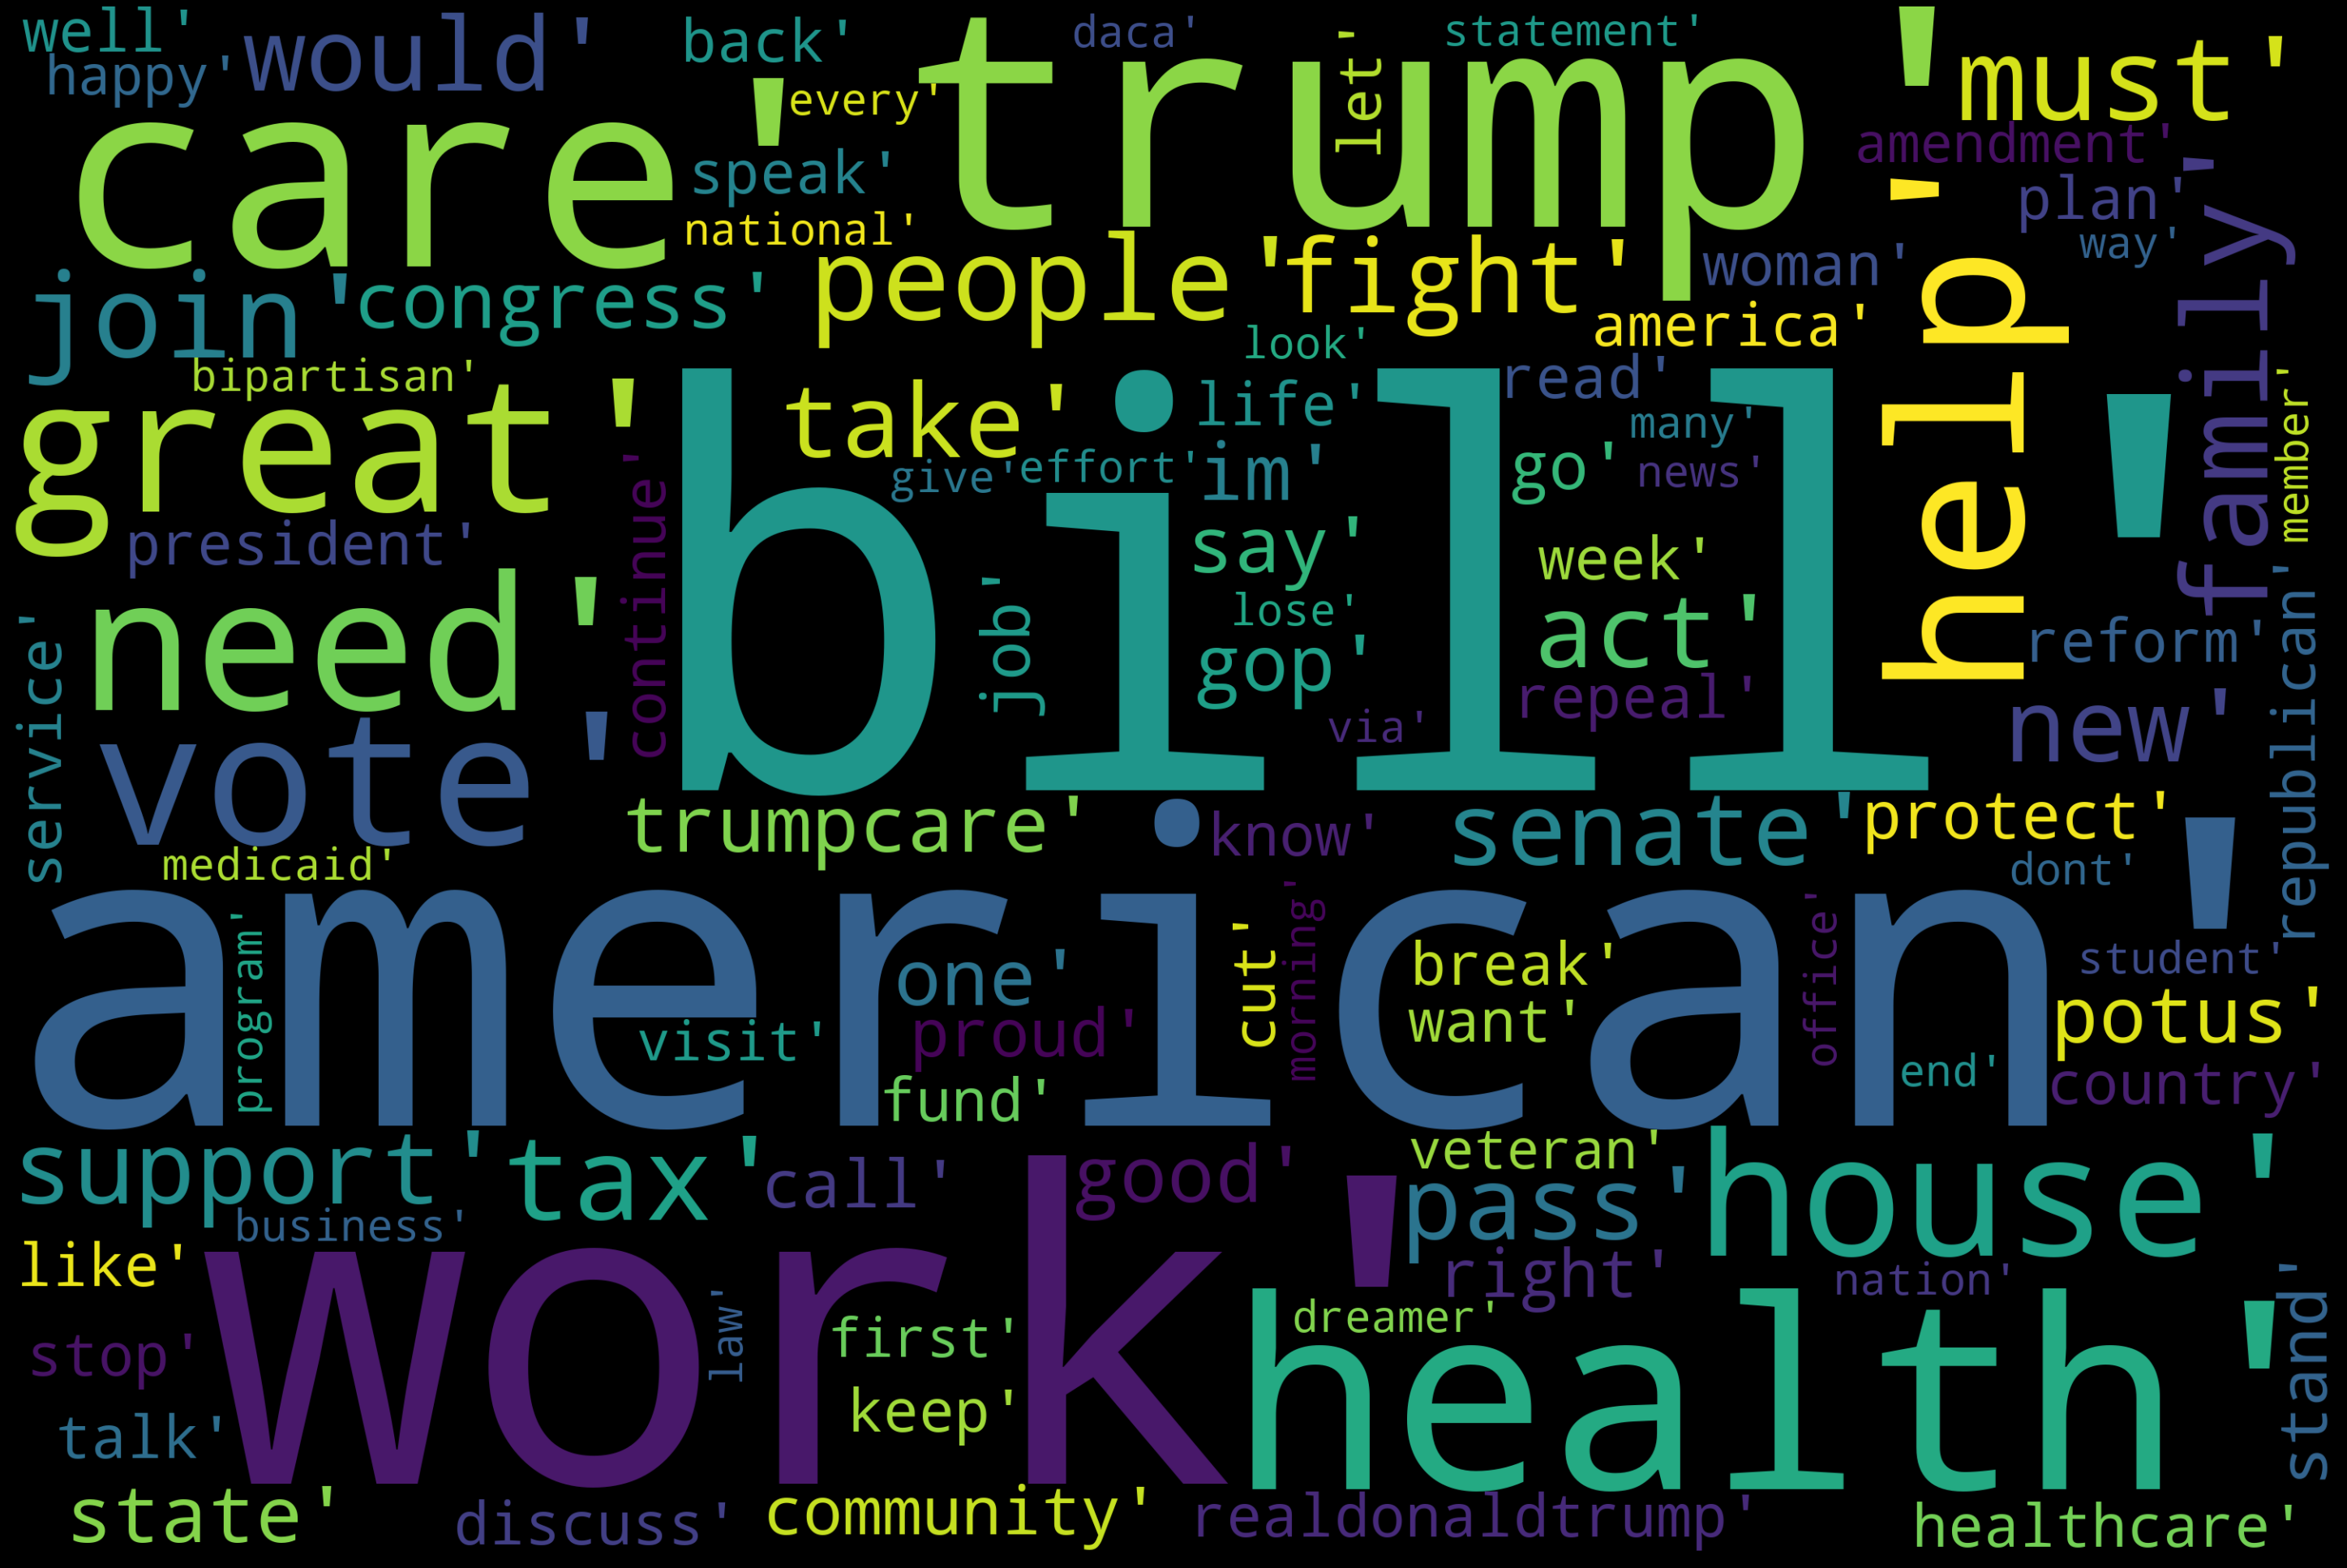

In [31]:
counts_pd3 = counts_pd.head(100)
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
text = counts_pd3.Most_Frequent_Words.values
wordcloud = WordCloud(
    width = 3000,
    height = 2000,
    background_color = 'black',
    stopwords = STOPWORDS).generate(str(text))
fig = plt.figure(
    figsize = (40, 30),
    facecolor = 'k',
    edgecolor = 'k')
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

# 2018

In [32]:
congDF0118 = spark.read.csv("s3://502finalprojbucky/congresstweets/data/Jan2018.csv/*.part",header=True)
congDF0218 = spark.read.csv("s3://502finalprojbucky/congresstweets/data/Feb2018.csv/*.part",header=True)
congDF0318 = spark.read.csv("s3://502finalprojbucky/congresstweets/data/Mar2018.csv/*.part",header=True)
congDF0418 = spark.read.csv("s3://502finalprojbucky/congresstweets/data/Apr2018.csv/*.part",header=True)
congDF0518 = spark.read.csv("s3://502finalprojbucky/congresstweets/data/May2018.csv/*.part",header=True)
congDF0618 = spark.read.csv("s3://502finalprojbucky/congresstweets/data/June2018.csv/*.part",header=True)
congDF0718 = spark.read.csv("s3://502finalprojbucky/congresstweets/data/July2018.csv/*.part",header=True)
congDF0818 = spark.read.csv("s3://502finalprojbucky/congresstweets/data/Aug2018.csv/*.part",header=True)
congDF0918 = spark.read.csv("s3://502finalprojbucky/congresstweets/data/Sep2018.csv/*.part",header=True)
congDF1018 = spark.read.csv("s3://502finalprojbucky/congresstweets/data/Oct2018.csv/*.part",header=True)
congDF1118 = spark.read.csv("s3://502finalprojbucky/congresstweets/data/Nov2018.csv/*.part",header=True)
congDF1218 = spark.read.csv("s3://502finalprojbucky/congresstweets/data/Dec2018.csv/*.part",header=True)

In [33]:
cong_2018 = sc.union([congDF0118.rdd,congDF0218.rdd,
                     congDF0318.rdd,congDF0418.rdd,
                     congDF0518.rdd,congDF0618.rdd,
                     congDF0718.rdd,congDF0818.rdd,
                     congDF0918.rdd,congDF1018.rdd,
                     congDF1118.rdd,congDF1218.rdd]).toDF()

In [34]:
cong_2018.cache()

DataFrame[id: string, screen_name: string, user_id: string, time: string, link: string, text: string, source: string]

In [35]:
data = cong_2018.filter(cong_2018['text'].isNull() == False)
cong_2018_token = pipeline.fit(data).transform(data)
all_words = cong_2018_token.withColumn("Most_Frequent_Words", explode(col("finished_clean_lemma")))
counts = all_words.groupby('Most_Frequent_Words').count()
counts_pd = counts.orderBy(desc('count')).toPandas()
counts_pd2 = counts_pd.head(15)

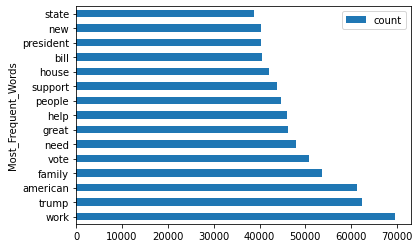

In [36]:
ax = counts_pd2.plot.barh(x='Most_Frequent_Words', y='count', rot=0)

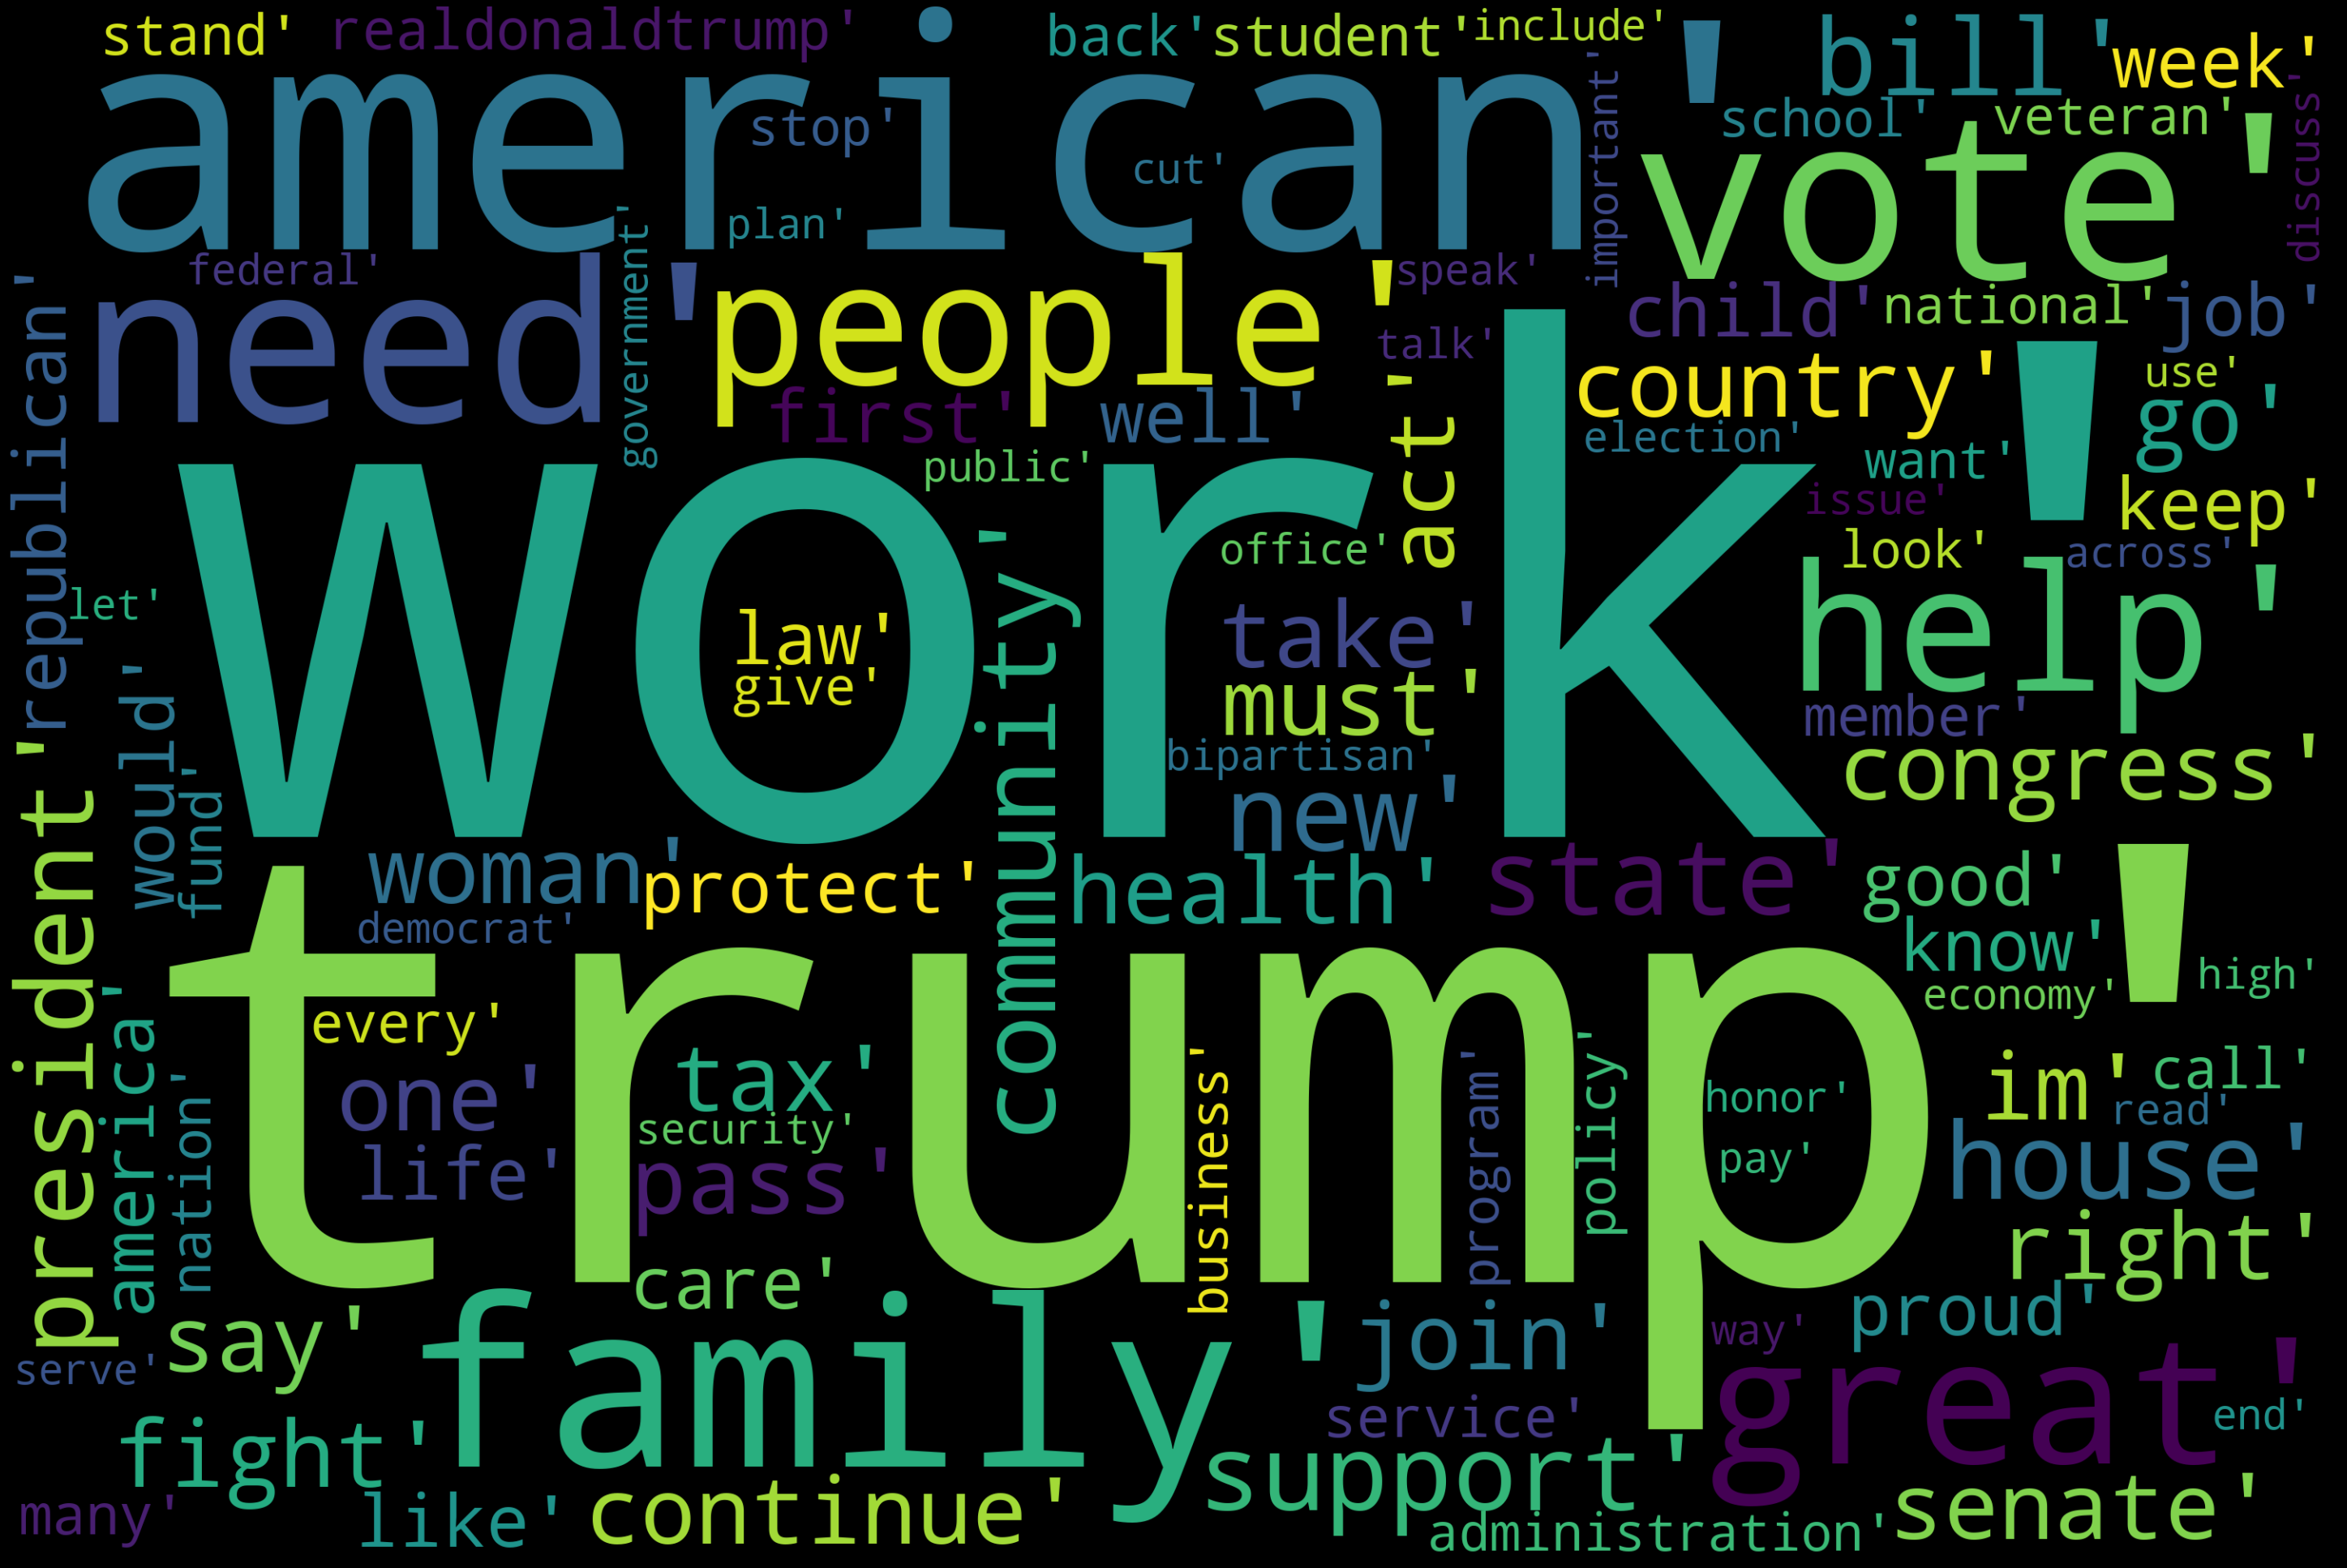

In [37]:
counts_pd3 = counts_pd.head(100)
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
text = counts_pd3.Most_Frequent_Words.values
wordcloud = WordCloud(
    width = 3000,
    height = 2000,
    background_color = 'black',
    stopwords = STOPWORDS).generate(str(text))
fig = plt.figure(
    figsize = (40, 30),
    facecolor = 'k',
    edgecolor = 'k')
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

# 2019

In [38]:
congDF0119 = spark.read.csv("s3://502finalprojbucky/congresstweets/data/Jan2019.csv/*.part",header=True)
congDF0219 = spark.read.csv("s3://502finalprojbucky/congresstweets/data/Feb2019.csv/*.part",header=True)
congDF0319 = spark.read.csv("s3://502finalprojbucky/congresstweets/data/Mar2019.csv/*.part",header=True)
congDF0419 = spark.read.csv("s3://502finalprojbucky/congresstweets/data/Apr2019.csv/*.part",header=True)
congDF0519 = spark.read.csv("s3://502finalprojbucky/congresstweets/data/May2019.csv/*.part",header=True)
congDF0619 = spark.read.csv("s3://502finalprojbucky/congresstweets/data/June2019.csv/*.part",header=True)
congDF0719 = spark.read.csv("s3://502finalprojbucky/congresstweets/data/July2019.csv/*.part",header=True)
congDF0819 = spark.read.csv("s3://502finalprojbucky/congresstweets/data/Aug2019.csv/*.part",header=True)
congDF0919 = spark.read.csv("s3://502finalprojbucky/congresstweets/data/Sep2019.csv/*.part",header=True)
congDF1019 = spark.read.csv("s3://502finalprojbucky/congresstweets/data/Oct2019.csv/*.part",header=True)
congDF1119 = spark.read.csv("s3://502finalprojbucky/congresstweets/data/Nov2019.csv/*.part",header=True)
congDF1219 = spark.read.csv("s3://502finalprojbucky/congresstweets/data/Dec2019.csv/*.part",header=True)

In [39]:
cong_2019 = sc.union([congDF0119.rdd,congDF0219.rdd,
                     congDF0319.rdd,congDF0419.rdd,
                     congDF0519.rdd,congDF0619.rdd,
                     congDF0719.rdd,congDF0819.rdd,
                     congDF0919.rdd,congDF1019.rdd,
                     congDF1119.rdd,congDF1219.rdd]).toDF()

In [40]:
data = cong_2019.filter(cong_2019['text'].isNull() == False)
cong_2019_token = pipeline.fit(data).transform(data)
all_words = cong_2019_token.withColumn("Most_Frequent_Words", explode(col("finished_clean_lemma")))
counts = all_words.groupby('Most_Frequent_Words').count()
counts_pd = counts.orderBy(desc('count')).toPandas()
counts_pd2 = counts_pd.head(15)

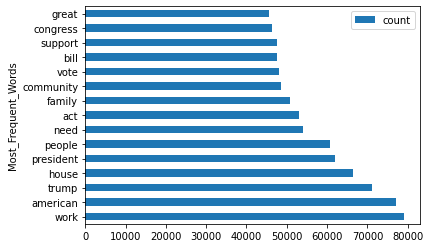

In [41]:
ax = counts_pd2.plot.barh(x='Most_Frequent_Words', y='count', rot=0)

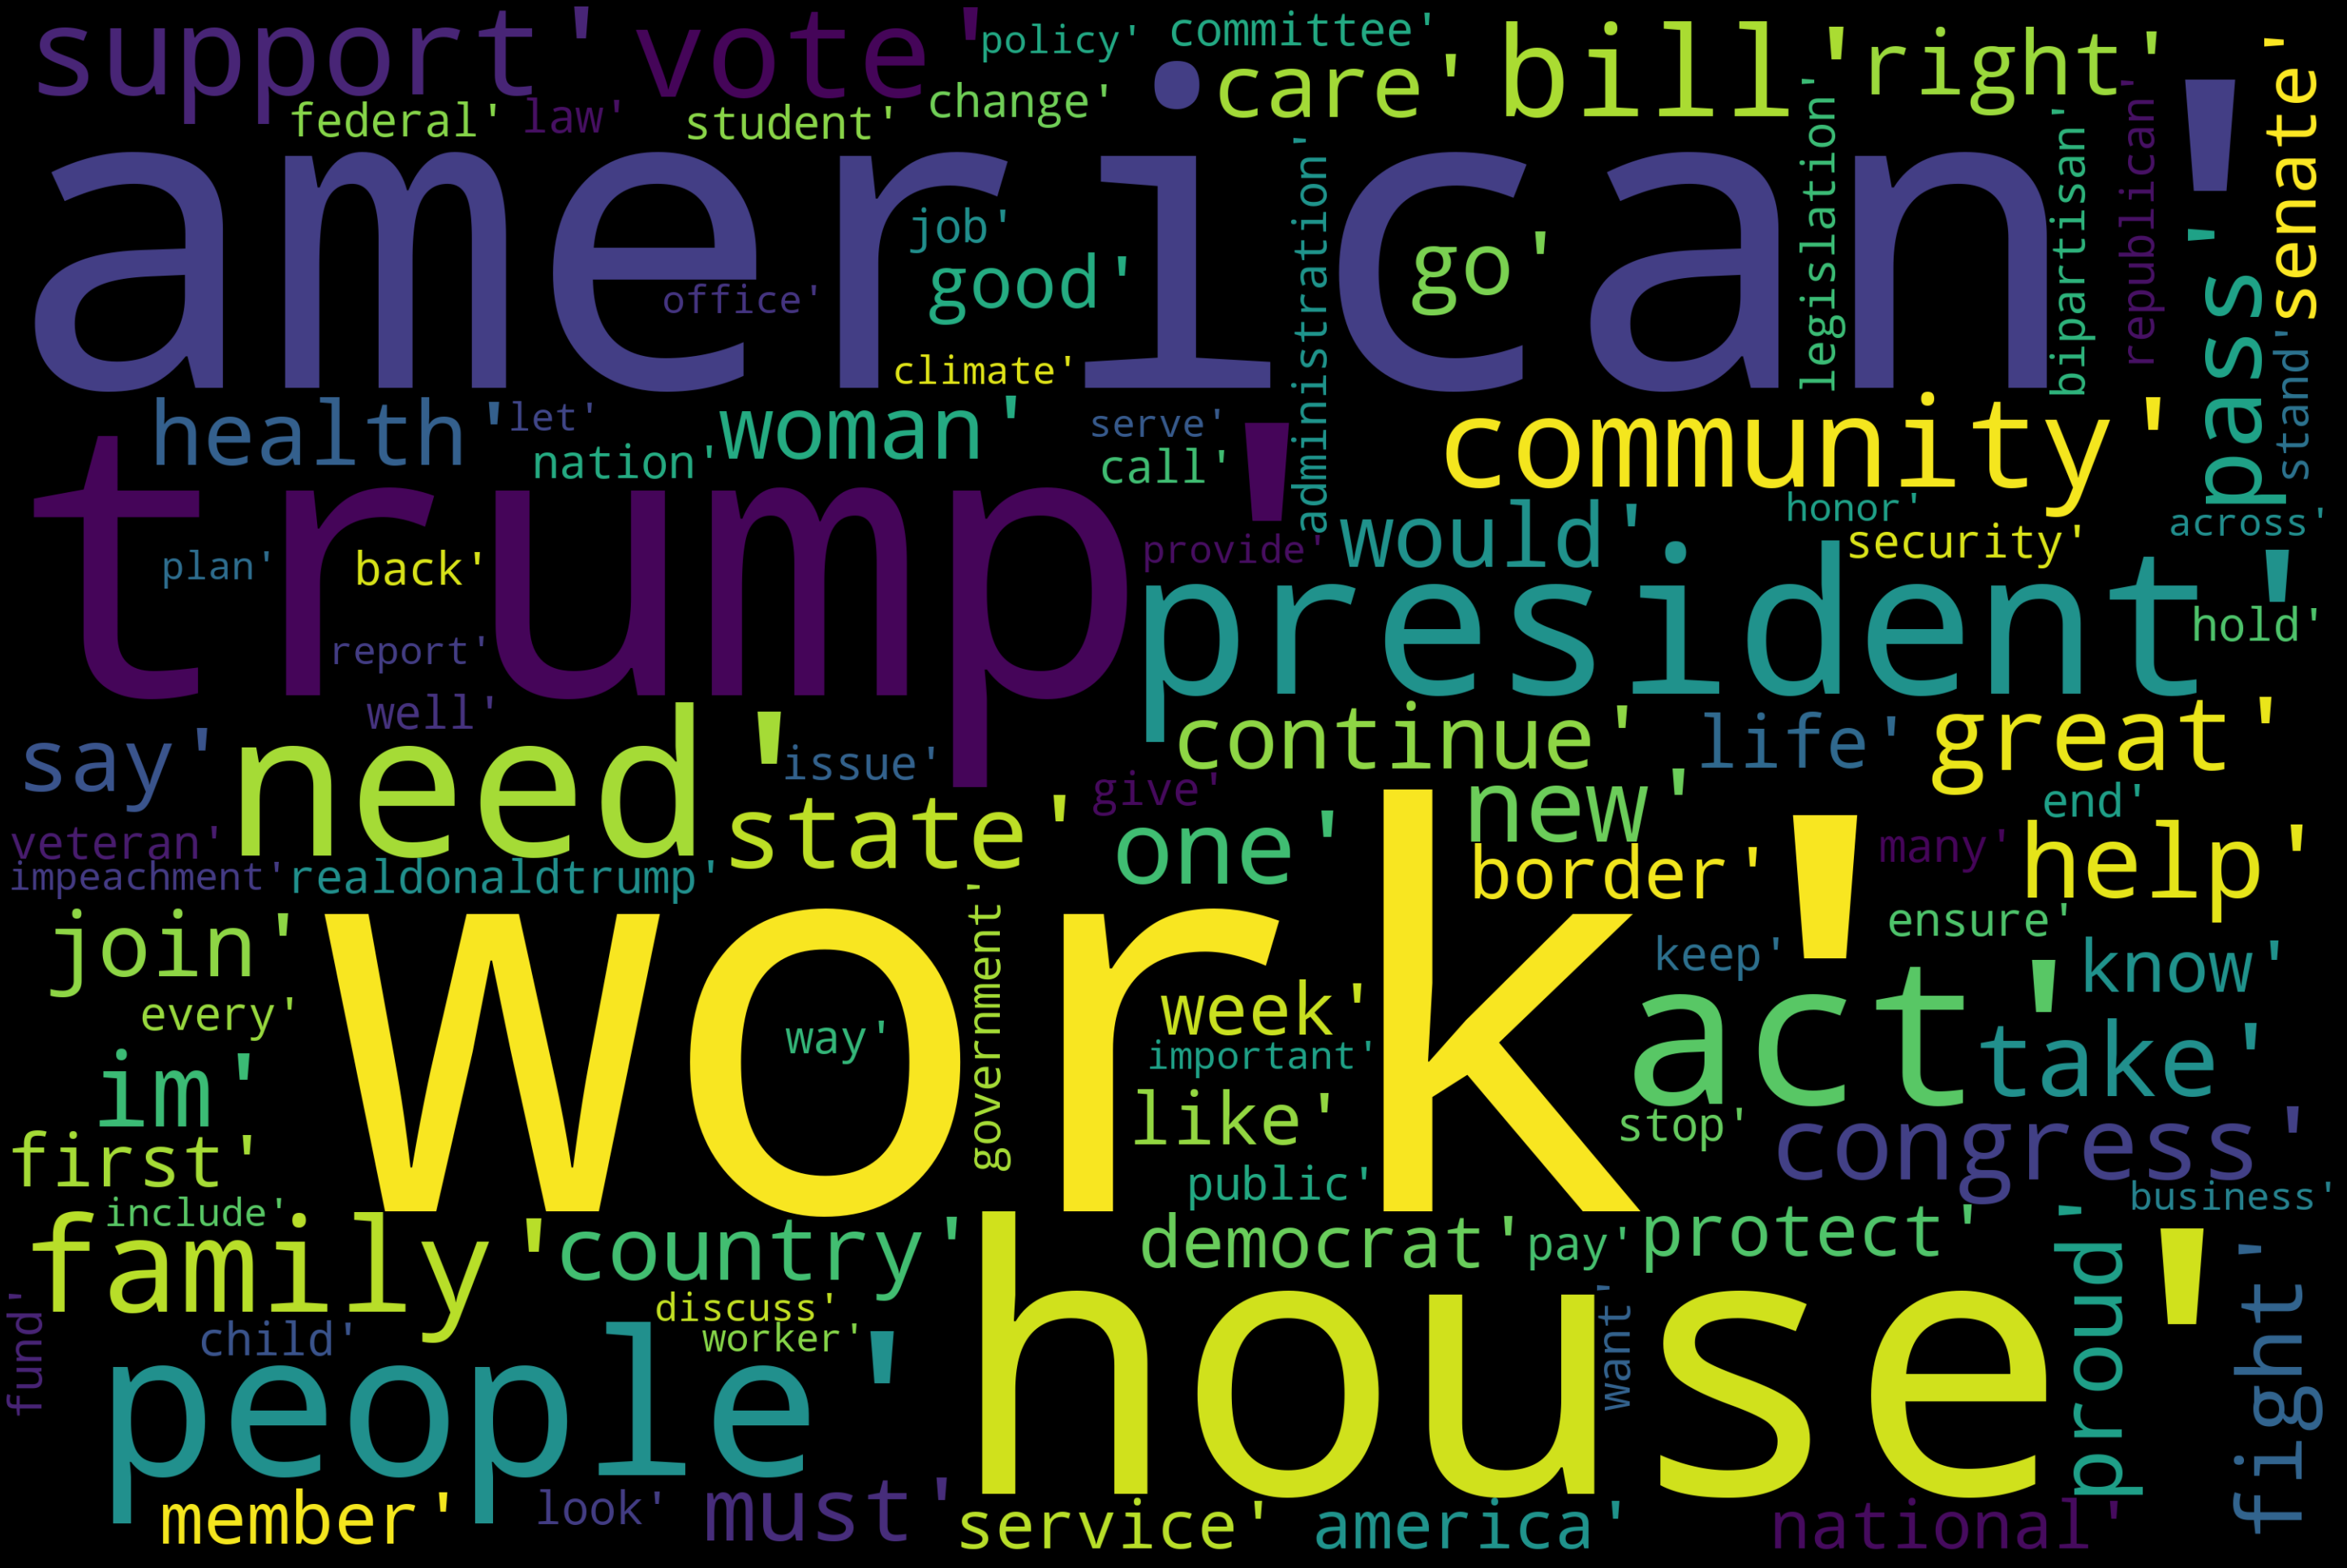

In [42]:
counts_pd3 = counts_pd.head(100)
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
text = counts_pd3.Most_Frequent_Words.values
wordcloud = WordCloud(
    width = 3000,
    height = 2000,
    background_color = 'black',
    stopwords = STOPWORDS).generate(str(text))
fig = plt.figure(
    figsize = (40, 30),
    facecolor = 'k',
    edgecolor = 'k')
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

# InfoOp

In [43]:
InfoOp = spark.read.csv("s3://502finalprojbucky/InfOpEnglish/*.csv")

In [44]:
InfoOp = InfoOp.dropDuplicates().withColumn("tweet_text",InfoOp["_c3"]).select("tweet_text")

In [45]:
InfoOp = InfoOp.filter(InfoOp["tweet_text"].isNull()==False)

In [46]:
InfoOp.show(5)

+--------------------+
|          tweet_text|
+--------------------+
|RT @Avraham5772: ...|
|RT @BBCWorld: #Ni...|
|I just wanna feel...|
|RT @deray: I love...|
|"RT @bfraser747: ...|
+--------------------+
only showing top 5 rows



In [47]:
documentAssembler = DocumentAssembler() \
    .setInputCol('tweet_text') \
    .setOutputCol('document')

tokenizer = Tokenizer() \
    .setInputCols(['document']) \
    .setOutputCol('token')

# note normalizer defaults to changing all words to lowercase.
# Use .setLowercase(False) to maintain input case.
normalizer = Normalizer() \
    .setInputCols(['token']) \
    .setOutputCol('normalized') \
    .setLowercase(True)

# note that lemmatizer needs a dictionary. So I used the pre-trained
# model (note that it defaults to english)
lemmatizer = LemmatizerModel.pretrained() \
    .setInputCols(['normalized']) \
    .setOutputCol('lemma') \

stopwords_cleaner = StopWordsCleaner() \
    .setInputCols(['lemma']) \
    .setOutputCol('clean_lemma') \
    .setCaseSensitive(False) \
    .setStopWords(eng_stopwords)

# finisher converts tokens to human-readable output
finisher = Finisher() \
    .setInputCols(['clean_lemma']) \
    .setCleanAnnotations(False)

lemma_antbnc download started this may take some time.
Approximate size to download 907.6 KB
[OK!]


In [48]:
pipeline = Pipeline() \
    .setStages([
        documentAssembler,
        tokenizer,
        normalizer,
        lemmatizer,
        stopwords_cleaner,
        finisher
    ])

In [49]:
InfoOps_token = pipeline.fit(InfoOp).transform(InfoOp)
all_words = InfoOps_token.withColumn("Most_Frequent_Words", explode(col("finished_clean_lemma")))
counts = all_words.groupby('Most_Frequent_Words').count()
counts_pd = counts.orderBy(desc('count')).toPandas()
counts_pd2 = counts_pd.head(15)

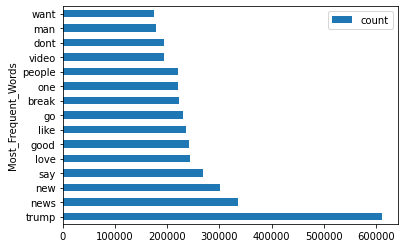

In [50]:
ax = counts_pd2.plot.barh(x='Most_Frequent_Words', y='count', rot=0)

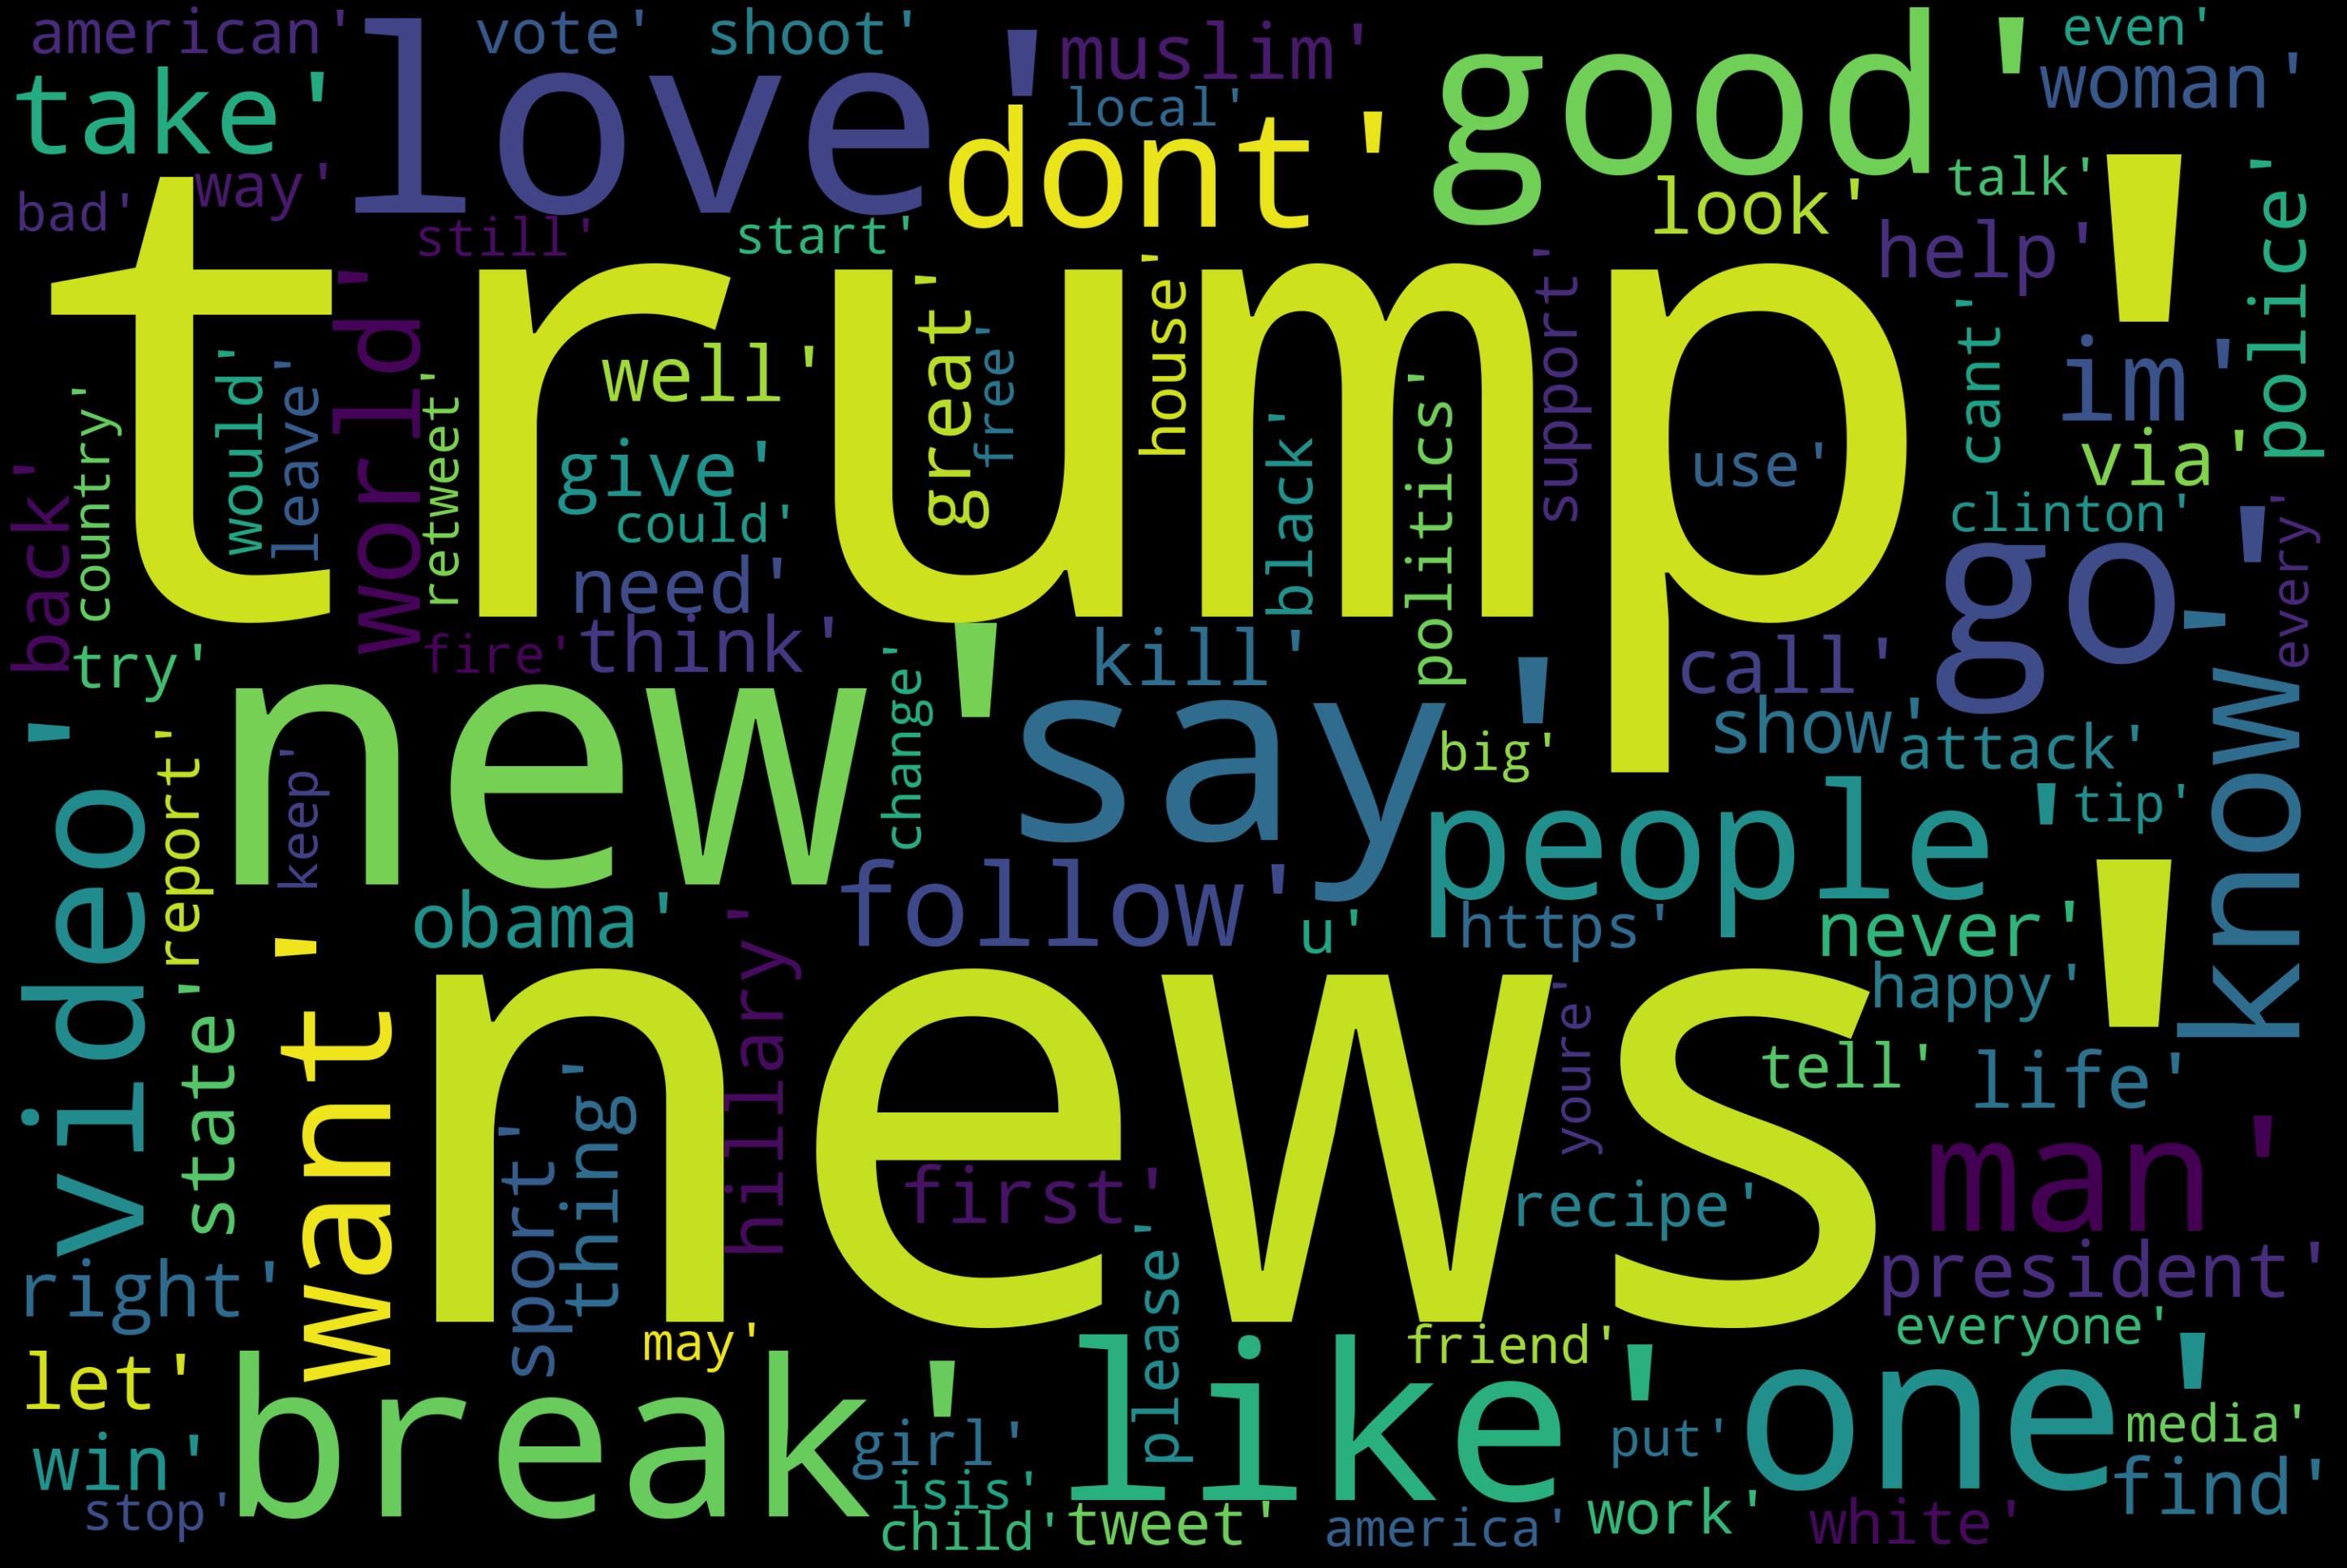

In [51]:
counts_pd3 = counts_pd.head(100)
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
text = counts_pd3.Most_Frequent_Words.values
wordcloud = WordCloud(
    width = 3000,
    height = 2000,
    background_color = 'black',
    stopwords = STOPWORDS).generate(str(text))
fig = plt.figure(
    figsize = (40, 30),
    facecolor = 'k',
    edgecolor = 'k')
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

In [52]:
sc.stop()